# I've tried to make a model that is hard to train with backprop
53k parameters CNN with 52 convolutional layers, 26 in encoder and 26 in decoder

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


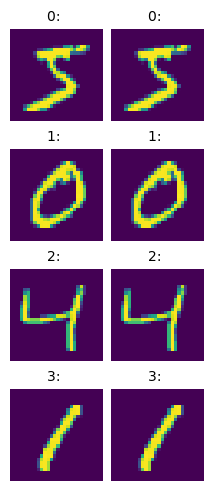

In [1]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets import MNIST
dstrain, dstest = MNIST.get_mnist_classification()
dstrain = DSToTarget.from_external_dataset(dstrain)
dstest = DSToTarget.from_external_dataset(dstest)
dstrain.preload()
dstest.preload()
dstrain.preview()

def show_preds(samples, inferer):
    inputs, targets = zip(*samples)
    inputs = torch.stack(inputs)
    preds = inferer(inputs)
    fig = Figure()
    fig.add().imshow_batch(inputs,None).style_img("Inputs")
    fig.add().imshow_batch(preds, None).style_img("Preds")
    fig.show(nrow=1, figsize=(8,8))

In [2]:
class UltraLongCNN(nn.Module):
    def __init__(self, ch=2, length=20):
        super().__init__()
        self.encoder = seq(conv(1, int(ch), 2, act=nn.ReLU()), *[conv(int(i*ch), int((i+1)*ch), 2, act=nn.ReLU()) for i in range(1, length)])
        self.decoder = seq(*[convt(int((i+1)*ch), int(i*ch), 2, act=nn.ReLU()) for i in range(length-1, 0, -1)], convt(int(ch), 1, 2, act=nn.ReLU()), )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

summary(UltraLongCNN(1, 27), (1, 1, 28,28))
print(count_parameters(UltraLongCNN(1, 27)))

path                                         module                                       input size               output size              params    buffers   
__main__.UltraLongCNN/encoder/0/0            torch.nn.modules.conv.Conv2d                 (1, 1, 28, 28)           (1, 1, 27, 27)           5         0         
__main__.UltraLongCNN/encoder/0/1            torch.nn.modules.activation.ReLU             (1, 1, 27, 27)           (1, 1, 27, 27)           0         0         
__main__.UltraLongCNN/encoder/1/0            torch.nn.modules.conv.Conv2d                 (1, 1, 27, 27)           (1, 2, 26, 26)           10        0         
__main__.UltraLongCNN/encoder/1/1            torch.nn.modules.activation.ReLU             (1, 2, 26, 26)           (1, 2, 26, 26)           0         0         
__main__.UltraLongCNN/encoder/2/0            torch.nn.modules.conv.Conv2d                 (1, 2, 26, 26)           (1, 3, 25, 25)           27        0         
__main__.UltraLongCNN/encoder/2/1 

# AdamW
We start with backprop using AdamW

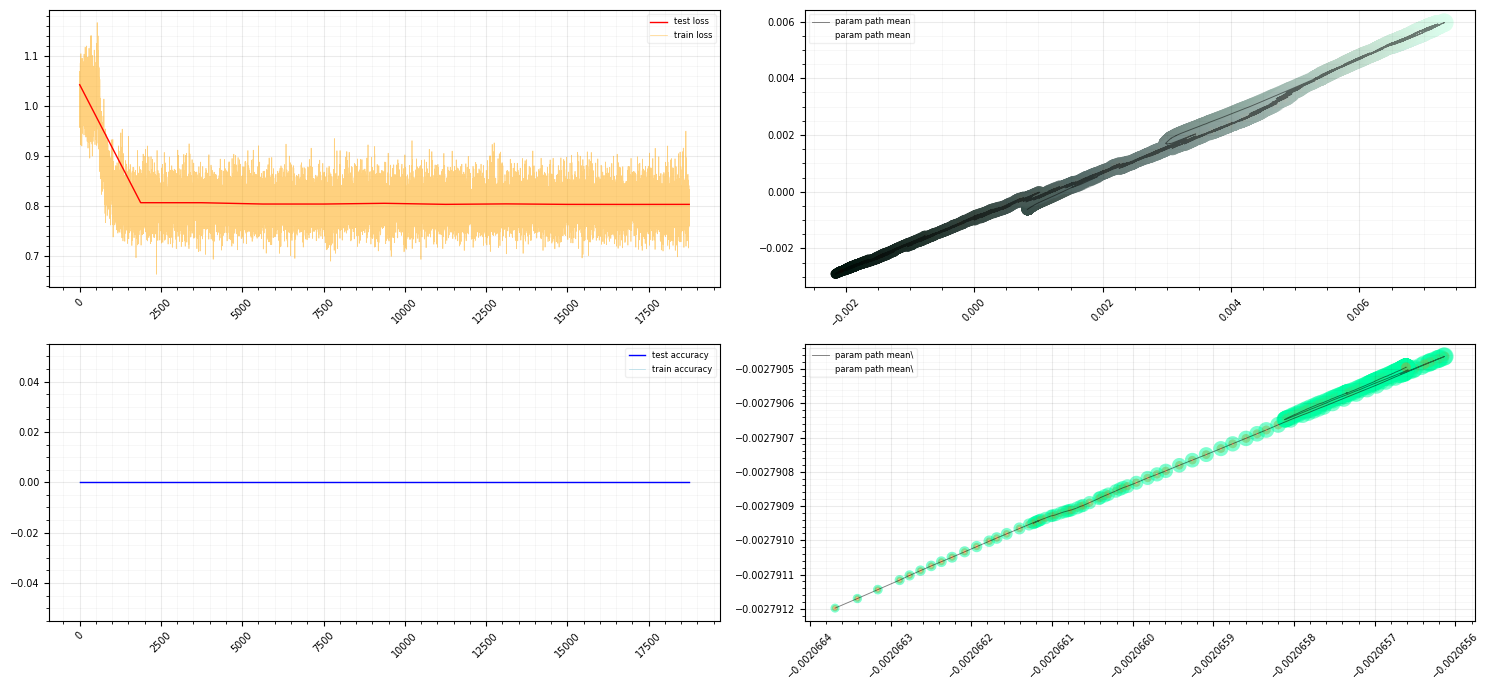

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 02m:21s/ops, elapsed: 21m:10s, rem: 02m:21s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 38.97ops/s, elapsed: 8.01s, rem: 26ms | 
train loss:                              last = 0.778, min = 0.663, max = 1.167
test loss:                               last = 0.803, min = 0.803, max = 1.042
train accuracy:                          last = 0.000, min = 0.000, max = 0.000
test accuracy:                           last = 0.000, min = 0.000, max = 0.000

test loss: min: 0.8031; max: 1.0425; last: 0.8032
test accuracy: min: 0.0000; max: 0.0000; last: 0.0000
param mean: min: -0.0023; max: 0.0067; last: -0.0022
param var: min: 0.0048; max: 0.0061; last: 0.0061
param min: min: -1.0701; max: -0.4935; last: -1.0655
param max: min: 0.4154; max: 0.4757; last: 0.4156
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0000; max: 0.0049; last: 0.0000
time: min: 10.0587; max: 1408.7186; last: 1408.7186
lr: min: 0.0000; max: 0.0010; last: 0.0000
train loss: min: 0.6634; max: 1.1668; last: 0.7781
train accuracy: min: 0.0000; max: 0.0000; last: 0.0000
last updates std: min: 0.0000; max: 0.0002; last: 0.0000


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


FileNotFoundError: [Errno 2] No such file or directory: 'summary graphs/AdamW 1e-03 onecycle testloss-0.803.png'

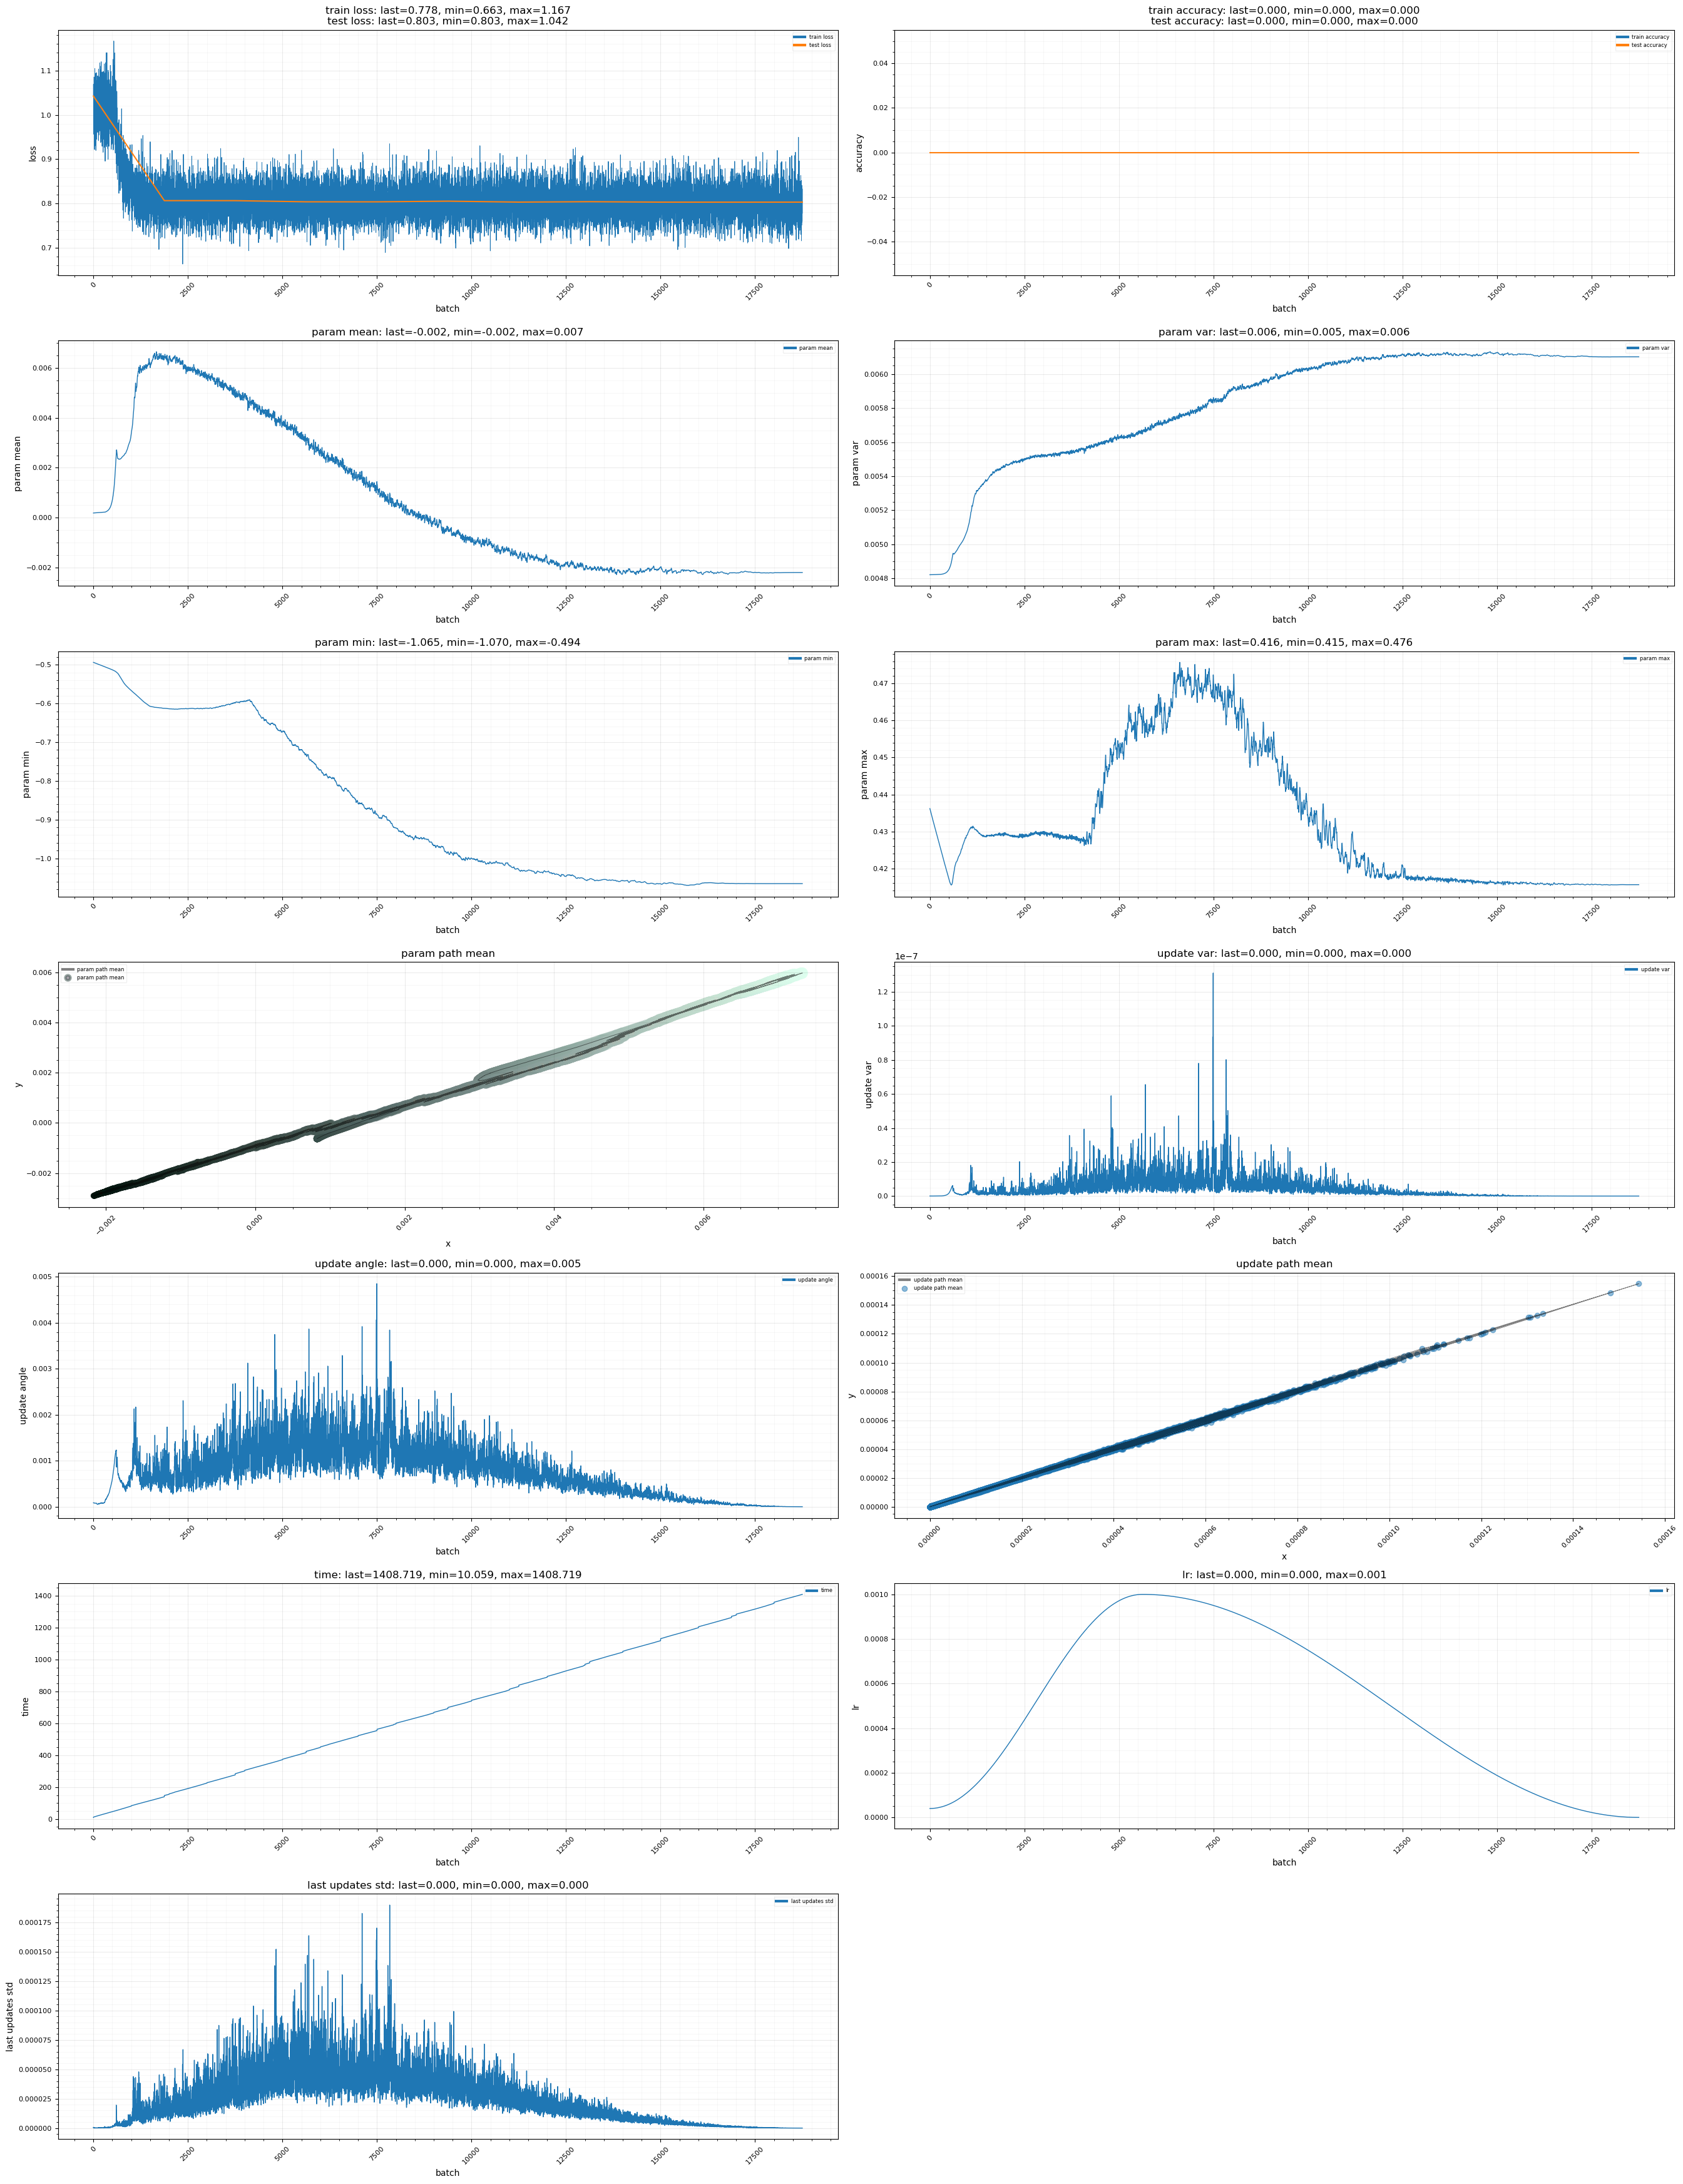

In [ ]:
with seeded_rng(): MODEL = UltraLongCNN(1, 27)
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.MSELoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)
    
OPT = torch.optim.AdamW(MODEL.parameters(), lr=LR)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = lr_scheduler.OneCycleLR(OPT, LR, len(DLTRAIN) * N_EPOCHS)

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            Log_Time(),
            Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            #GradientFreeWithZeroGrad(),
            #OneBatch_ClosureWithNoBackward()
              )
clean_mem()


# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"{get__name__(OPT)} {LR:.0e} onecycle"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST)
show_preds(dstest.__getitems__(range(12)), learner.inference)

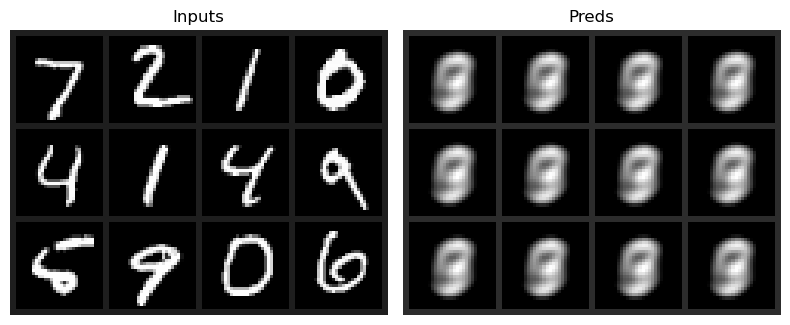

In [ ]:
show_preds(dstest.__getitems__(range(12)), learner.inference)

# RandomGrad
Its actually slower than AdamW despite not calculating gradients, and loss is worse

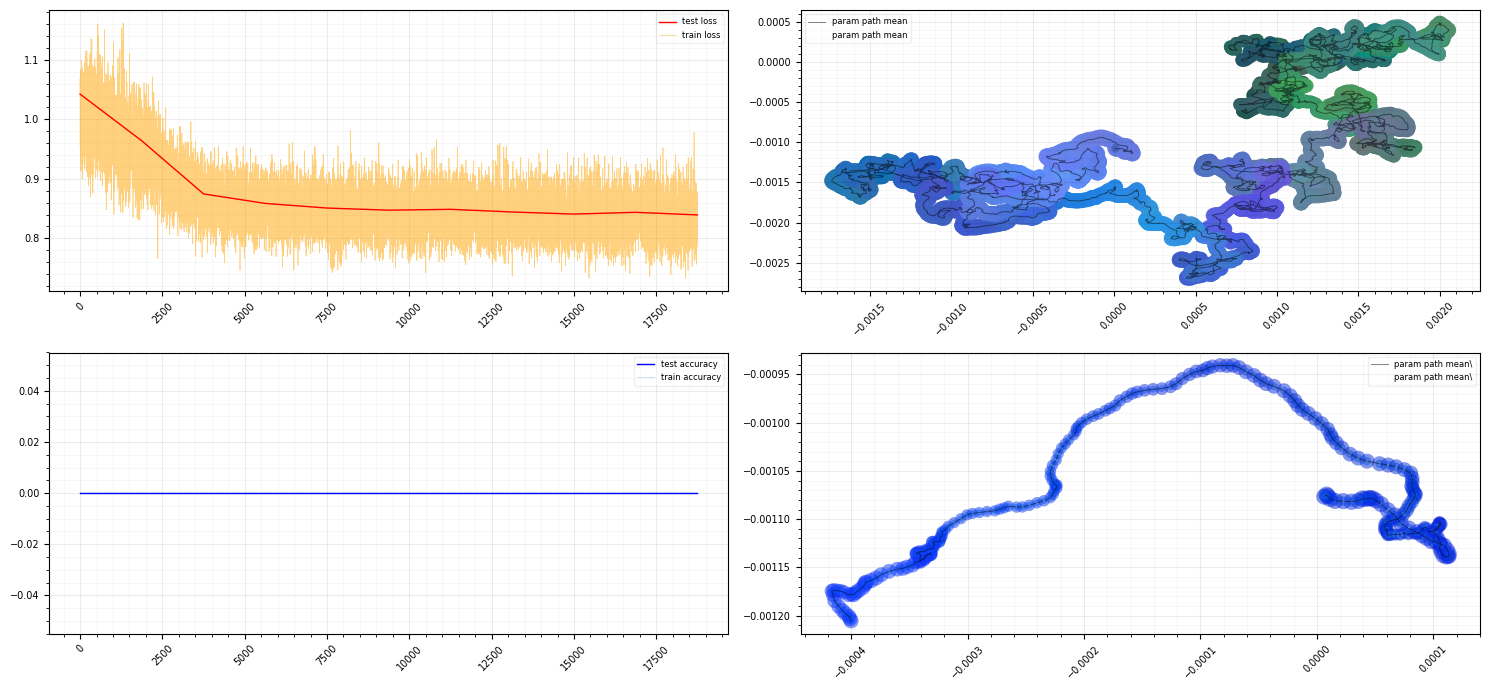

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 03m:05s/ops, elapsed: 27m:49s, rem: 03m:05s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 43.97ops/s, elapsed: 7.10s, rem: 23ms | 
train loss:                              last = 0.812, min = 0.733, max = 1.162
test loss:                               last = 0.844, min = 0.841, max = 1.042
train accuracy:                          last = 0.000, min = 0.000, max = 0.000
test accuracy:                           last = 0.000, min = 0.000, max = 0.000

test loss: min: 0.8395; max: 1.0425; last: 0.8395
test accuracy: min: 0.0000; max: 0.0000; last: 0.0000
param mean: min: 0.0001; max: 0.0011; last: 0.0005
param var: min: 0.0048; max: 0.0191; last: 0.0191
param min: min: -0.5780; max: -0.4600; last: -0.5428
param max: min: 0.4051; max: 0.7839; last: 0.7216
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0016; max: 0.0144; last: 0.0017
time: min: 8.7247; max: 1844.1891; last: 1844.1891
train loss: min: 0.7328; max: 1.1624; last: 0.8124
train accuracy: min: 0.0000; max: 0.0000; last: 0.0000
last updates std: min: 0.0001; max: 0.0003; last: 0.0001


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


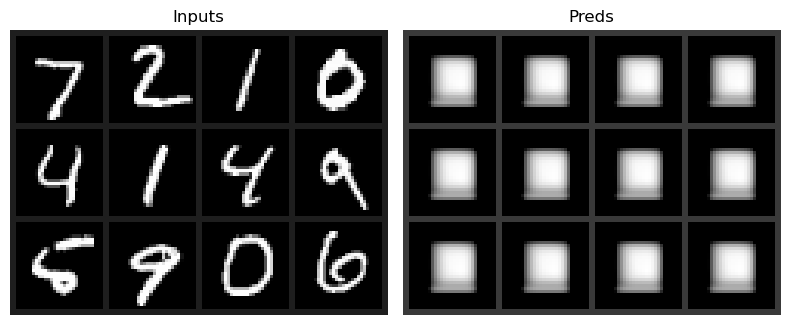

In [3]:
from torchzero.optim import RandomGrad

with seeded_rng(): MODEL = UltraLongCNN(1, 27)
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.MSELoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

OPT = RandomGrad(MODEL.parameters(), magn=1e-5, opt=optim.AdamW(MODEL.parameters(), lr=1e-3))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
# SCHED = lr_scheduler.OneCycleLR(OPT, LR, len(DLTRAIN) * N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()


# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"{get__name__(OPT)} 1e-5 AdamW {LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST)
show_preds(dstest.__getitems__(range(12)), learner.inference)

# AdamSPSA
Everybody says magnitude should decay so it could be better

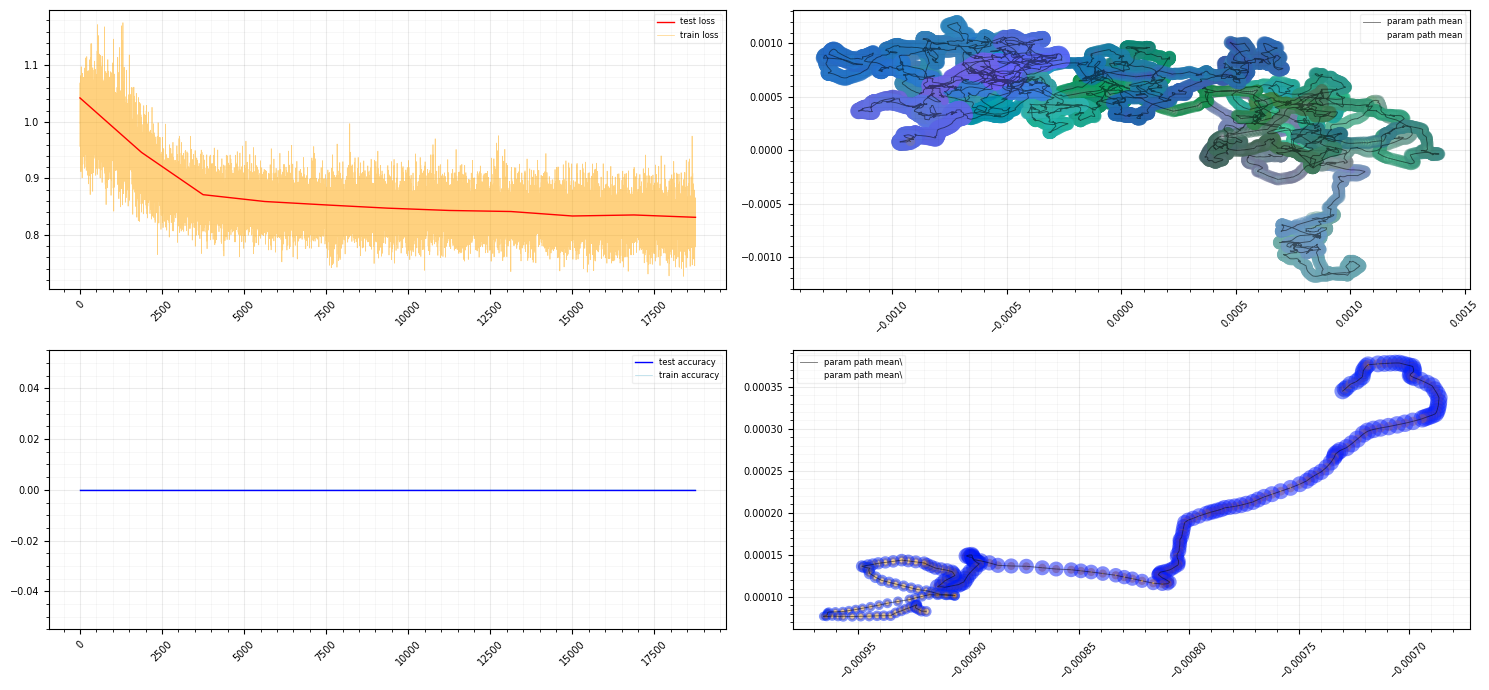

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉     | 10/10 | 04m:26s/ops, elapsed: 40m:02s, rem: 04m:26s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 313/313 | 44.11ops/s, elapsed: 7.07s, rem: 23ms | 
train loss:                              last = 0.802, min = 0.727, max = 1.176
test loss:                               last = 0.835, min = 0.833, max = 1.042
train accuracy:                          last = 0.000, min = 0.000, max = 0.000
test accuracy:                           last = 0.000, min = 0.000, max = 0.000

test loss: min: 0.8311; max: 1.0425; last: 0.8311
test accuracy: min: 0.0000; max: 0.0000; last: 0.0000
param mean: min: -0.0005; max: 0.0003; last: 0.0001
param var: min: 0.0048; max: 0.0215; last: 0.0215
param min: min: -0.7677; max: -0.4922; last: -0.7614
param max: min: 0.3843; max: 0.7301; last: 0.6834
update var: min: 0.0000; max: 0.0000; last: 0.0000
update angle: min: 0.0003; max: 0.0144; last: 0.0008
time: min: 9.5423; max: 2693.9600; last: 2693.9600
train loss: min: 0.7266; max: 1.1758; last: 0.8019
train accuracy: min: 0.0000; max: 0.0000; last: 0.0000
last updates std: min: 0.0000; max: 0.0003; last: 0.0000


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


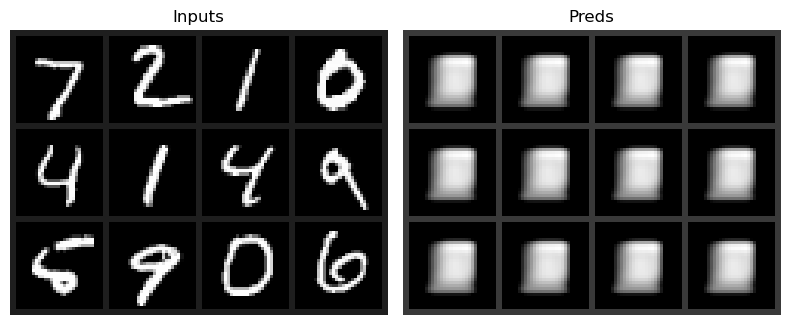

In [3]:
from torchzero.optim import SPSA

with seeded_rng(): MODEL = UltraLongCNN(1, 27)
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.MSELoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

OPT = SPSA(MODEL.parameters(), magn=1e-5, grad=True, opt=optim.AdamW(MODEL.parameters(), lr=1e-3))
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
# SCHED = lr_scheduler.OneCycleLR(OPT, LR, len(DLTRAIN) * N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()


# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"{get__name__(OPT)} 1e-5 AdamW {LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST)
show_preds(dstest.__getitems__(range(12)), learner.inference)

# Swarm of 4 optimizers
It is Ultra Slow

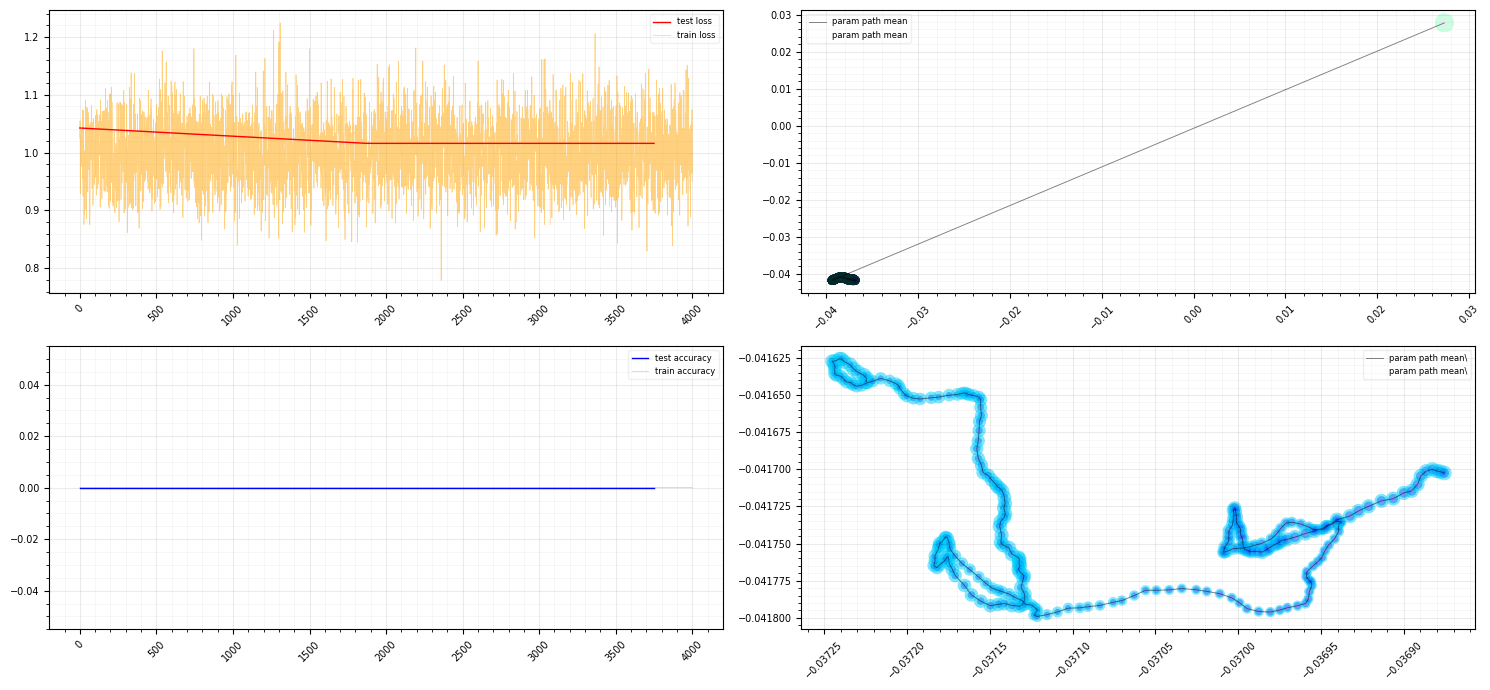

▉▉▉▉▉▉▉▉▉▉▉                                        | 3/10 | 19m:14s/ops, elapsed: 38m:29s, rem: 02h:33m:59s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉                                    | 495/1875 | 1.63ops/s, elapsed: 05m:02s, rem: 14m:05s | 
train loss:                              last = 0.994, min = 0.779, max = 1.224
test loss:                               last = 1.016, min = 1.016, max = 1.042
train accuracy:                          last = 0.000, min = 0.000, max = 0.000
test accuracy:                           last = 0.000, min = 0.000, max = 0.000

In [3]:
from torchzero.optim import SwarmOfOptimizers, RandomGrad, SPSA

with seeded_rng(): MODEL = UltraLongCNN(1, 27)
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
LOSS_FN = nn.MSELoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

optimizers = [RandomGrad(MODEL.parameters(), magn=1e-5, opt=optim.AdamW(MODEL.parameters(), lr=1e-3)),
              RandomGrad(MODEL.parameters(), magn=1e-5, opt=optim.AdamW(MODEL.parameters(), lr=2e-3)),
              SPSA(MODEL.parameters(), magn=1e-5, opt=optim.AdamW(MODEL.parameters(), lr=1e-3)),
              SPSA(MODEL.parameters(), magn=1e-5, opt=optim.AdamW(MODEL.parameters(), lr=2e-3))
              ]
OPT = SwarmOfOptimizers(MODEL.parameters(), optimizers, old_steps=5, die_after=20, crossover_p=0.9, init_each=True)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
# SCHED = lr_scheduler.OneCycleLR(OPT, LR, len(DLTRAIN) * N_EPOCHS)
SCHED = None

CALLBACKS = (Metric_Loss(),
            Metric_Accuracy(True,False),
            Log_ParamDist(METRIC_STEP),
            Log_ParamPath(METRIC_STEP),
            Log_UpdateDist(METRIC_STEP),
            Log_UpdatePath(METRIC_STEP),
            Log_LastUpdatesAngle(METRIC_STEP),
            Log_Time(),
            #Log_LR(),
            Summary(),
            Accelerate("no"),
            PerformanceTweaks(True),
            Save_Last(),
            LivePlot(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBar(),
            PlotSummary(path = 'summary graphs'),
            GradientFreeWithZeroGrad(),
            OneBatch_ClosureWithNoBackward()
              )
clean_mem()


# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"{get__name__(OPT)} RandomGradx2 SPSAx2"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST)
show_preds(dstest.__getitems__(range(12)), learner.inference)